# Ultimate takehome challenge

### Part 1

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

We start off by importing the necessary liabries and the json file containing the login data

In [538]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import plotly.plotly as py
import plotly.graph_objs as go
from pandas import Grouper
%matplotlib inline

In [539]:
login = pd.read_json('logins.json')

We look at the head of our newly created dataframe, it looks like we only have one column. We want to do a few things to this dataframe so that it is useful for us. Firstly we want to group the data into 15 minute invervals, then we want a count of how many logins occoured in that 15 minute period.

In [540]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


We start off by doing a bit of data cleaning. We first convert the date column into a datetime data type. We then create a second column called temp, we do this so that we can count the ammount of logins. We then create a third column called index, we do this so that we can index the dataframe on this column

In [541]:
login['login_time'] = pd.to_datetime(login['login_time'])
login['temp'] = 1
login['index'] = login['login_time']

We set the index of the dataframe to the newly created index column

In [542]:
login = login.set_index('index')

We then perform a groupby opperation on our dataframe, we group the dataframe by 15 minute intervals (based off of our datetime index), and we sum the number of the temp column, this gives us the ammount of logins per 15 minute interval

In [543]:
login = login.groupby(pd.Grouper(freq='15Min'))['temp'].sum()
login = pd.DataFrame(login)

We then reset the index, this creates a new index and saves our datetime index as a column in the dataframe. We also fill in the nan values of our temp column to zero since we know that nans will occour in 15 minute intervals where there were no logins

In [544]:
login.reset_index()
login['temp'] = login['temp'].fillna(value=0)

We then create a time series graph to display the ammount of logins over the period. We use plotly since it creates an interactive graph that allows us to look at both the overall trend, and specific time periods that are of interest to us. 

In [552]:
data = [go.Scatter(x=login.index, y=login.temp)]
layout = go.Layout(title='Ultimate Logins', xaxis=dict(title='Date'), yaxis=dict(title='Total Logins (per 15 mins)'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

From the chart we can see that logins follow a cyclical pattern. There are two main cycles we can see from the data. The first is that users tend to login at night time around midnight, then also tend to login around lunchtime. This trend seems to carry over throughout the whole week but is most apparent on the weekdays.

The second trend that can be observed is that users tend to login more on the weekends at night time, this may be due to users enjoying themselves on the weekend and needing a sober driver to take them home.  

Of these two patterns the weekends seem to cause the largest spikes in logins, the largest spike in logins appears to have occurred on March 1st at 4:30am, which was a Sunday morning. This seems to give credence to the idea that Ultimate users tend to use the service more when they go out on the weekend.

Regarding data quality issues, the login data don't seem to have any issues, although there are some 15 minute periods in which no user logged in, this is not likely to the fact that no users logged in rather that an issue with data quality. Additionally there doesn't appear to be any missing days in the dataset

### Part 2

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    a) how you will implement the experiment
    b) what statistical test(s) you will conduct to verify the significance of the observation
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

1) This is really dependant on what data we have access to. If we have access to the drivers location we could create a variable which logs where a driver picked up a pasanger. By looking at percentage of passangers the driver picked up in a particular city we would be able to determin how well our experiment went. The closer the percentage is to 50% the more succesful the campaign was since 50% would indicate that the driver is displaying no preference for a particular city.

2) To perform the experiment we would need to start logging where the pasangers were picked up from before the experiment takes place, this would be our control. Once we have obtained enough data for our control we would perform the experiment and log the results. We would need to look at the percentage of trips originating from a particular city, if the distribution of the data is normal we would be able to perform a z-test or a t-test.

We would test the null hypothesis that there is no difference in the pre and post experiment percentage, the alternative hypothesis would be that there is a statisticaly significant difference between the two distributions. Note that we would use a one tail test since we only care about a lowering of the percentage. If the experiment is a success we would have accepted the null hypothesis, this would mean that the percentage of trips originating from a particular city is closer to 50%, meaning that drivers are more likely to pick passengers up from the other city.

### Part 3

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. 
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

We start off by importing the Json file containing the dataset

In [419]:
file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

We then look at the head of our dataframe, and use the info method to see the datatypes of the variables and to see how many missing values we have

In [373]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null int64
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null int64
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 4.6 MB


We can see that we are missing some values in the ratings column for the driver and passanger. Since there are so few missing values we simply fill in the missing variables using the mean value of the variable. We also want to convert the signup and last trip date to a datetime variable. Additionally we create a new variable called retained, this variable is our binary output variable, it tells us whether or not the customer is still using the app in the sixth month after signing up (June 2014, since all the users in the dataset signed up in January), this will be the target variable of our predictive model. We then look at the head of our cleaned dataset

In [554]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)

In [421]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [422]:
df['retained'] = np.nan
df.loc[df['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df.loc[df['last_trip_date'] < '2014-06-01', 'retained'] = 0
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0


We will now focus on some of the variable to see how they are distributed, and to see if they may have any predictive power for our model 

## Average Distance

From the average distance distribution graph on the left we can see that users tend to take shorter trips. While there is a large variance in the data, from the comparative boxplot we can see that users who were retained tend to take slightly shorter trips than those who were not retained.

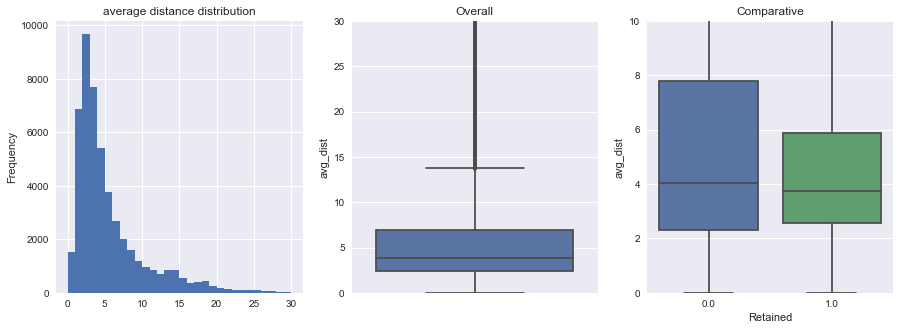

In [555]:
plt.subplot(1, 3, 1)
amountplt = df.avg_dist.plot( kind='hist', bins = 30, range=(0,30), figsize=(15,5))
plt.title('average distance distribution')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="avg_dist", data=df)
plt.ylim(0, 30)
plt.title('Overall')

plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(x="retained", y="avg_dist", data=df)
#stepbox2.set_yscale('log')
plt.ylim(0, 10)
stepbox2.set(xlabel='Retained')
plt.title('Comparative')

## Trips in first 30 days

From the Trips in first 30 days distribution graph on the left we can see that users tend to only take a couple of trips in their first month. From the comparative boxplot we can see that users who take more trips tend to be more likely to continue using the app and thus be retained. The customers who leave the ap take on average one trip, where as those who are retained take an average of 2 trips on their first month

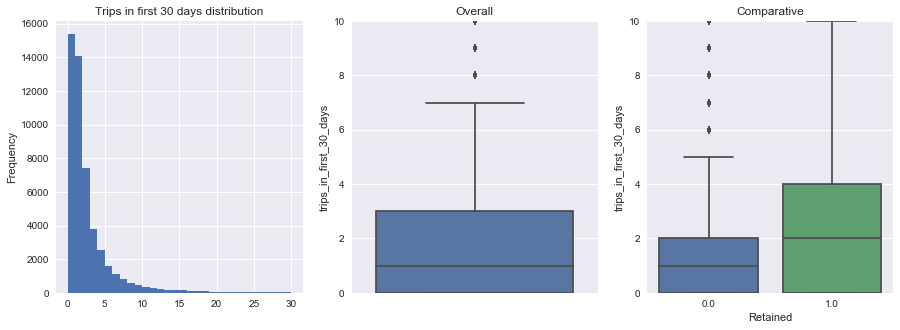

In [565]:
plt.subplot(1, 3, 1)
amountplt = df.trips_in_first_30_days.plot( kind='hist', bins = 30, range=(0,30), figsize=(15,5))
plt.title('Trips in first 30 days distribution')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="trips_in_first_30_days", data=df)
plt.ylim(0, 10)
plt.title('Overall')

plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(x="retained", y="trips_in_first_30_days", data=df)
#stepbox2.set_yscale('log')
plt.ylim(0, 10)
stepbox2.set(xlabel='Retained')
plt.title('Comparative')

## Weekend percentage

This variable shows us what percentage of the users logins was on the weekend. The distribution graph looks polarizing, we can see that there are two main groups of users, those who use it exclusively on the weekend, and those who use it exclusively on the weekend. Looking at the comparative graph it looks as though those who login on weekdays are more likely to be retained

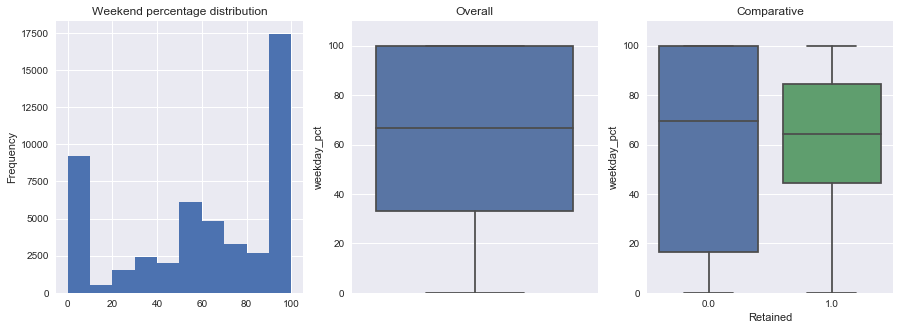

In [558]:
plt.subplot(1, 3, 1)
amountplt = df.weekday_pct.plot( kind='hist', bins = 10, range=(0,100), figsize=(15,5))
plt.title('Weekend percentage distribution')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="weekday_pct", data=df)
plt.ylim(0, 110)
plt.title('Overall')

plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(x="retained", y="weekday_pct", data=df)
#stepbox2.set_yscale('log')
plt.ylim(0, 110)
stepbox2.set(xlabel='Retained')
plt.title('Comparative')

#### Model creation

We will now create a model to predict whether or not a user will be retained. We start off by encoding some of the non numeric values using a label encoder. We then split the dataframe into input and output variable dataframes X and y. We then  split this data into a training and testing set, we use 20% for testing. Finally we convert our training data into a DMartix so that it can be feed into our XGBoost model

In [423]:
lb_make = LabelEncoder()

categories = ['city', 'phone', 'signup_date', 'ultimate_black_user', 'last_trip_date']
for col in categories: 
    df[col] = lb_make.fit_transform(df[col])

In [425]:
X = df.drop(['retained', 'last_trip_date'], axis=1)
y = df['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

We then perform cross validation to check the predictive ability of our model. We use 10 folds for our cross validation and after 500 rounds of boosting we have a mean root mean squared error of 0.381016 on the testing folds.

In [472]:
params = {"objective":"reg:logistic", "eta":0.08, "max_depth":3, "subsample":0.9, "colsample_bytree":0.9}
cv_results = xgb.cv(dtrain=dmatrix, params=params, as_pandas=True, num_boost_round=500, nfold=10, seed=27)
print(cv_results[-10:])

     test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
490        0.381022       0.003402         0.371463        0.000395
491        0.381024       0.003404         0.371440        0.000394
492        0.381029       0.003406         0.371421        0.000392
493        0.381027       0.003404         0.371397        0.000392
494        0.381029       0.003401         0.371380        0.000392
495        0.381033       0.003403         0.371363        0.000391
496        0.381027       0.003399         0.371341        0.000391
497        0.381022       0.003403         0.371318        0.000391
498        0.381016       0.003401         0.371298        0.000392
499        0.381016       0.003401         0.371281        0.000395


It may be interesting to see how the model improves with each successive round of bosting. To show this we create a graph which shows how each successive round of boosting effects the mean RMSE of the test folds. From the graph we can see that we get very little improvement in accuracy after 500 rounds of boosting. Thus we limit the number of rounds to 500 to avoid creating an unnecessarily complex model 

In [470]:
cv_results = xgb.cv(dtrain=dmatrix, params=params, num_boost_round=800, as_pandas=True, metrics='rmse', nfold=10, seed=27)
results = pd.DataFrame(cv_results)
results['round'] = range(1, len(results) + 1)

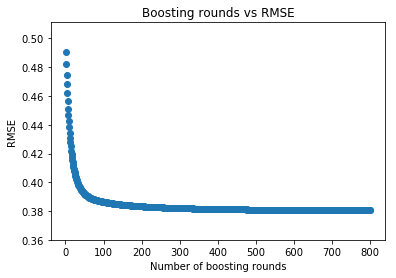

In [471]:
plt.scatter(results['round'], results['test-rmse-mean'])
plt.xlabel('Number of boosting rounds')
plt.ylabel('RMSE')
plt.title('Boosting rounds vs RMSE')

Now that we know the model is working well we create a classifier using the same parameters as our cross validation and we fit it to the training data. We then use the model to predict the test data. Finally we print out a confusion matrix and accuracy score so that we can evaluate the performance of the model

In [475]:
xg_cl = xgb.XGBClassifier(objective="reg:logistic", n_estimators=500, learning_rate=0.08, max_depth=3, subsample=0.9, colsample_bytree=0.9)
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict(X_test)
print(classification_report(y_test,preds))

             precision    recall  f1-score   support

        0.0       0.81      0.86      0.83      6190
        1.0       0.75      0.66      0.70      3810

avg / total       0.79      0.79      0.78     10000



In [476]:
print(accuracy_score(y_test,preds))

0.7875


With an overall f1 score of 0.78 and an accuracy of 0.7875, we can see that our model does an acceptable job of predicting which customers will be retained. Since the model has predictive ability, we want to look at which features are important for predicting retention.
From the chart below we can see that average distance, weekend percent and trips in first 30 days are the three most predictive features. In the exploratory data analysis we saw that users who are retained tend to take slightly shorter trips, use the app less on the weekend, and tend to take more trips in their first 30 days.

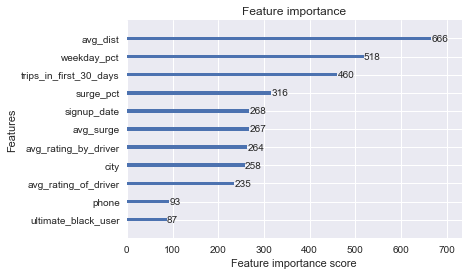

In [561]:
model = xgb.train(params=params, dtrain=dmatrix, num_boost_round=500)
xgb.plot_importance(model, xlabel='Feature importance score',)
plt.show()